# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


---
# Projet H2023 : Prédiction du prix des diamants


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/2126c40a2d454beb8bd36d168581c968

Ce calepin Jupyter de base permet de charger les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- train.csv
- test.csv

**Déposez ces fichiers dans le répertoire de ce calepin.**

Le fichier *train.csv* contient le prix de vente en dollar américain de 40 455 diamants en fonction des caractéristiques suivantes :

- cut : qualité de coupe (Fair, Good, Very Good, Premium, Ideal)
- color : couleur du diamant (de J (pire) à D (meilleure)
- clarity : clarté du diamant (I1 (pire), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (meilleure))
- x: longueur en mm 
- y: largeur en mm
- z: profondeur en mm
- depth: pourcentage de la profondeur exprimée comme 2*z/(x+y)
- table: pourcentage de la largeur du sommet du diamant par rapport au point le plus large 

Le fichier test.csv contient les caractéristiques de 13 485 diamants pour lesquels vous devriez prédire le prix de vente. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.


### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. Vous devriez développer une méthode d'imputation (de remplacement) des données manquantes.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

In [95]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
import Random
using GLM
using Statistics
import StatsBase
import Plots

---
## 1. Chargement de données

In [96]:
data = CSV.read("train.csv", DataFrame)
# first(data, 5)
first(sort(data, [:price], rev=true), 5)

Row,ID,cut,color,clarity,depth,table,price,x,y,z
,Int64,String15?,String1,String7,Float64?,Float64,Int64,Float64,Float64?,Float64
1,4422,Premium,I,VS2,60.9,60.0,18823,8.49,8.46,5.16
2,35311,Ideal,G,SI2,62.6,55.0,18804,8.2,8.13,5.11
3,11882,Premium,I,VS1,60.8,59.0,18795,8.12,8.04,4.91
4,21157,Premium,H,SI1,58.1,60.0,18795,8.37,8.3,4.84
5,8394,Ideal,G,SI2,62.7,54.0,18792,8.28,8.34,5.21


In [97]:
test = CSV.read("test.csv", DataFrame)
println(nrow(test))
println(nrow(dropmissing(test)))

replace!(test.y, 31.8 => 5.15)
replace!(test.z, 31.8 => 5.15)

# first(test, 5)
first(sort(dropmissing(test), [:y], rev=true), 15)

13485
11491


Row,ID,cut,color,clarity,depth,table,x,y,z
,Int64,String15,String1,String7,Float64,Float64,Float64,Float64,Float64
1,2601,Premium,H,I1,62.1,58.0,9.45,9.38,5.85
2,6290,Fair,H,I1,56.2,62.0,9.53,9.37,5.31
3,2118,Premium,I,SI2,60.1,59.0,9.37,9.32,5.62
4,5909,Good,I,I1,57.0,64.0,9.39,9.31,5.33
5,7997,Premium,G,I1,58.6,60.0,9.12,9.06,5.33
6,5070,Fair,I,I1,65.2,56.0,9.11,9.02,5.91
7,9781,Premium,I,SI2,61.1,59.0,9.04,8.97,5.5
8,5773,Fair,I,SI2,65.7,56.0,9.0,8.95,5.9
9,5054,Premium,J,SI2,59.4,58.0,8.86,8.83,5.25


#### 1.1 Retirer les valeurs aberrantes de l'entrainement

In [98]:
println("Avec valeurs aberrantes: $(nrow(data))")
filter!((:x) => (x) -> (3 < x), data)
filter!((:y) => (y) -> ismissing(y) || (0 < y && y < 9.5), data)
filter!((:z) => (z) -> (2 < z && z < 6), data)
println("Sans valeurs aberrantes: $(nrow(data))")

Avec valeurs aberrantes: 40455


Sans valeurs aberrantes: 40425


#### Tableau qui permet d'attribuer un coefficient sachant cut et color

##### A Sample Diamond Price Chart ([source](https://www.gemsociety.org/article/what-determines-diamond-cost/))

<table class="dv5Tq"><tbody><tr><td colspan="12"><b><span class="Apple-converted-space">&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; </span>(0.46-0.49 CTS) <span class="Apple-converted-space">&nbsp; &nbsp; &nbsp; &nbsp; </span>DATE<span class="Apple-converted-space">&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; </span>ROUNDS <span class="Apple-converted-space">&nbsp; &nbsp; &nbsp;</span></b></td></tr><tr><td colspan="1"></td><td colspan="1"><b>IF</b></td><td colspan="1"><b>VVS1</b></td><td colspan="1"><b>VVS2</b></td><td colspan="1"><b>VS1</b></td><td colspan="1"><b>VS2</b></td><td colspan="1"><b>SI1</b></td><td colspan="1"><b>SI2</b></td><td colspan="1"><b>SI3</b></td><td colspan="1"><b>I1</b></td><td colspan="1"><b>I2</b></td><td colspan="1"><b>I3</b></td></tr><tr><td colspan="1"><b>D</b></td><td colspan="1">80</td><td colspan="1">65</td><td colspan="1">59</td><td colspan="1">49</td><td colspan="1">40</td><td colspan="1">34</td><td colspan="1">27</td><td colspan="1">24</td><td colspan="1">21</td><td colspan="1">15</td><td colspan="1">11</td></tr><tr><td colspan="1"><b>E</b></td><td colspan="1">65</td><td colspan="1">60</td><td colspan="1">51</td><td colspan="1">46</td><td colspan="1">39</td><td colspan="1">33</td><td colspan="1">26</td><td colspan="1">23</td><td colspan="1">20</td><td colspan="1">14</td><td colspan="1">10</td></tr><tr><td colspan="1"><b>F</b></td><td colspan="1">60</td><td colspan="1">52</td><td colspan="1">46</td><td colspan="1">43</td><td colspan="1">37</td><td colspan="1">31</td><td colspan="1">25</td><td colspan="1">22</td><td colspan="1">19</td><td colspan="1">13</td><td colspan="1">10</td></tr><tr><td colspan="1"><b>G</b></td><td colspan="1">52</td><td colspan="1">46</td><td colspan="1">42</td><td colspan="1">40</td><td colspan="1">35</td><td colspan="1">29</td><td colspan="1">24</td><td colspan="1">21</td><td colspan="1">18</td><td colspan="1">13</td><td colspan="1">9</td></tr><tr><td colspan="1"><b>H</b></td><td colspan="1">44</td><td colspan="1">40</td><td colspan="1">36</td><td colspan="1">34</td><td colspan="1">30</td><td colspan="1">27</td><td colspan="1">22</td><td colspan="1">19</td><td colspan="1">17</td><td colspan="1">12</td><td colspan="1">9</td></tr><tr><td colspan="1"><b>I</b></td><td colspan="1">35</td><td colspan="1">32</td><td colspan="1">30</td><td colspan="1">27</td><td colspan="1">25</td><td colspan="1">23</td><td colspan="1">21</td><td colspan="1">18</td><td colspan="1">16</td><td colspan="1">12</td><td colspan="1">9</td></tr><tr><td colspan="1"><b>J</b></td><td colspan="1">29</td><td colspan="1">27</td><td colspan="1">25</td><td colspan="1">24</td><td colspan="1">23</td><td colspan="1">22</td><td colspan="1">20</td><td colspan="1">17</td><td colspan="1">14</td><td colspan="1">12</td><td colspan="1">8</td></tr><tr><td colspan="1"><b>K</b></td><td colspan="1">23</td><td colspan="1">22</td><td colspan="1">21</td><td colspan="1">20</td><td colspan="1">19</td><td colspan="1">18</td><td colspan="1">16</td><td colspan="1">15</td><td colspan="1">13</td><td colspan="1">11</td><td colspan="1">8</td></tr><tr><td colspan="1"><b>L</b></td><td colspan="1">22</td><td colspan="1">21</td><td colspan="1">20</td><td colspan="1">19</td><td colspan="1">18</td><td colspan="1">17</td><td colspan="1">15</td><td colspan="1">13</td><td colspan="1">11</td><td colspan="1">10</td><td colspan="1">7</td></tr><tr><td colspan="1"><b>M</b></td><td colspan="1">18</td><td colspan="1">17</td><td colspan="1">17</td><td colspan="1">16</td><td colspan="1">15</td><td colspan="1">14</td><td colspan="1">13</td><td colspan="1">11</td><td colspan="1">10</td><td colspan="1">9</td><td colspan="1">6</td></tr></tbody></table>

In [99]:
d = [80, 65, 59, 49, 40, 34, 27, 24, 21, 15, 11]
e = [65, 60, 51, 46, 39, 33, 26, 23, 20, 14, 10]
f = [60, 52, 46, 43, 37, 31, 25, 22, 19, 13, 10]
g = [52, 46, 42, 40, 35, 29, 24, 21, 18, 13,  9]
h = [44, 40, 36, 34, 30, 27, 22, 19, 17, 12,  9]
i = [35, 32, 30, 27, 25, 23, 21, 18, 16, 12,  9]
j = [29, 27, 25, 24, 23, 22, 20, 17, 14, 12,  8]
k = [23, 22, 21, 20, 19, 18, 16, 15, 13, 11,  8]
l = [22, 21, 20, 19, 18, 17, 15, 13, 11, 10,  7]
m = [18, 17, 17, 16, 15, 14, 13, 11, 10,  9,  6]

price_chart = Dict(
    "D" => d,
    "E" => e,
    "F" => f,
    "G" => g,
    "H" => h,
    "I" => i,
    "J" => j,
    "K" => k,
    "L" => l,
    "M" => m,
)

clarity_to_column = Dict(
    "IF"   => 1,
    "VVS1" => 2,
    "VVS2" => 3,
    "VS1"  => 4,
    "VS2"  => 5,
    "SI1"  => 6,
    "SI2"  => 7,
    "I1"   => 9,
)

color_to_row = Dict(
    "D" => 0,
    "E" => 1,
    "F" => 2,
    "G" => 3,
    "H" => 4,
    "I" => 5,
    "J" => 6,
    "K" => 7,
    "L" => 8,
    "M" => 9,
)

Dict{String, Int64} with 10 entries:
  "L" => 8
  "I" => 5
  "J" => 6
  "M" => 9
  "D" => 0
  "G" => 3
  "E" => 1
  "K" => 7
  "F" => 2
  "H" => 4

---
## 2. Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de se familiariser avec les données. C'est une analyse exploratoire sommaire. Je vous encourage fortement à poursuivre cette analyse.

In [100]:
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,ID,20228.3,1,20228.0,40455,0,Int64
2,cut,,Fair,,Very Good,3804,"Union{Missing, String15}"
3,color,,D,,J,0,String1
4,clarity,,I1,,VVS2,0,String7
5,depth,61.7475,42.2,61.8,100.5,2199,"Union{Missing, Float64}"
6,table,57.4649,43.0,57.0,95.0,0,Float64
7,price,3934.35,326,2402.0,18823,0,Int64
8,x,5.73137,3.73,5.7,9.5,0,Float64
9,y,5.7329,3.67,5.71,9.46,2199,"Union{Missing, Float64}"


#### 2.1 Prix en fonction des mesures x y z


In [101]:
# p1 = Plots.plot(data.x, data.price, seriestype=:scatter, label="")
# Plots.xlabel!("x (en mm)")
# Plots.ylabel!("prix")

# p2 = Plots.plot(data.y, data.price, seriestype=:scatter, label="")
# Plots.xlabel!("y (en mm)")
# Plots.ylabel!("prix")

# p3 = Plots.plot(data.z, data.price, seriestype=:scatter, label="")
# Plots.xlabel!("z (en mm)")
# Plots.ylabel!("prix")

# Plots.plot(p1, p2, p3, layout = 3)

#### 2.2 Prix en fonction de la clarté

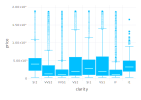

In [102]:
plot(data, x=:clarity, y=:price, Geom.boxplot)

#### Distribution des prix

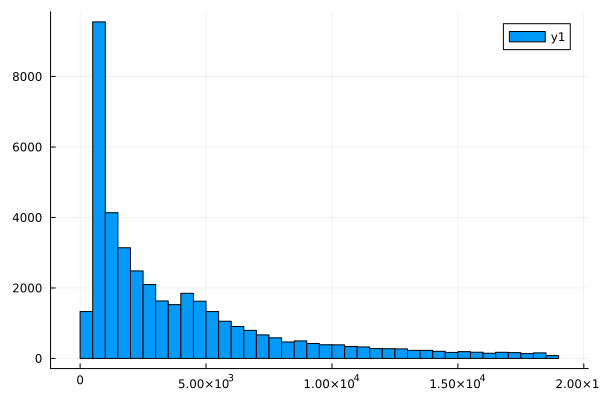

In [103]:
Plots.histogram(data.price)

#### Distribution des y

min y = 3.67, max y = 9.46


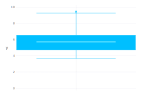

In [105]:
data_without_missing_y = dropmissing(data, :y, disallowmissing=true)
println("min y = $(minimum(data_without_missing_y.y)), max y = $(maximum(data_without_missing_y.y))")

# Plots.histogram(data_without_missing_y.y)
plot(data_without_missing_y, y=:y, Geom.boxplot)

In [106]:
# data.chart = [price_chart[data[i, :color]][clarity_to_column[data[i, :clarity]]] for i = 1:nrow(data)]
# data.color_num = [color_to_row[color] for color = data.color]
# data.clarity_num = [clarity_to_column[clarity] for clarity = data.clarity]

# cor(Matrix(select(data, [:table, :x, :z, :price])))
cor(Matrix(dropmissing(select(data, [:depth, :table, :x, :y, :z, :price]))))
# cor(Matrix(dropmissing(select(data, [:x, :z, :chart, :color_num, :clarity_num, :price]))))


6×6 Matrix{Float64}:
  1.0         -0.293948  -0.0204899  -0.0228987  0.104426  -0.00427632
 -0.293948     1.0        0.193228    0.187103   0.152483   0.126772
 -0.0204899    0.193228   1.0         0.998475   0.991546   0.886945
 -0.0228987    0.187103   0.998475    1.0        0.991243   0.888525
  0.104426     0.152483   0.991546    0.991243   1.0        0.882517
 -0.00427632   0.126772   0.886945    0.888525   0.882517   1.0

---
## 3. Ajustement d'un modèle de régression linéaire

Pour cet exemple simple, on n'utilise que la longueur du diamant pour prédire le prix dans un modèle de régression quadratique.

#### Séparer les données en ensemble d'entrainement/de validation

In [107]:
Random.seed!(3302)

ntrain = round(Int, 0.95 * nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

first(train, 5)

Row,ID,cut,color,clarity,depth,table,price,x,y,z
,Int64,String15?,String1,String7,Float64?,Float64,Int64,Float64,Float64?,Float64
1,1,missing,E,SI2,60.2,60.0,5340,6.46,6.5,3.9
2,2,Ideal,G,VVS2,62.7,57.0,1936,5.12,5.05,3.19
3,3,Premium,E,VVS1,62.0,59.0,1012,4.33,4.28,2.67
4,4,Ideal,G,VS2,61.7,57.0,720,4.41,4.38,2.71
5,5,missing,G,VS2,62.4,58.0,6301,6.41,6.48,4.02


In [108]:
nrow(data), nrow(train), nrow(valid)

(40425, 38404, 2021)

In [109]:
# train.chart = [price_chart[train[i, :color]][clarity_to_column[train[i, :clarity]]] for i = 1:nrow(train)]
# train.color_num = [color_to_row[color] for color = train.color]
# train.clarity_num = [clarity_to_column[clarity] for clarity = train.clarity]

# first(train, 5)

In [110]:
function plot_predictions(predictions::Vector{Number}, real_price::Vector{Number}, range::UnitRange{Int64})
    df = DataFrame(predictions=predictions, real_price=real_price)
    sort!(df, [:predictions])
    # sort!(df, [:real_price])

    Plots.plot(range, df.real_price[range], seriestype=:scatter, color=:red, label="vérité")
    Plots.plot!(range, df.predictions[range], seriestype=:scatter, color=:blue, label="prédiction")
    # Plots.xlabel!("# rangée (en ordre croissant de prédiction de prix)")
    Plots.ylabel!("prix")
end

plot_predictions(predictions, real_price) = plot_predictions(predictions, real_price, 1:length(predictions))


plot_predictions (generic function with 4 methods)

#### 3.3 Prédire les y avec une loi linéaire généralisée gamma

In [111]:
# model = glm(@formula(y ~ color * clarity * table * x * z), train, Normal(), IdentityLink())
y_model = glm(@formula(y ~ color * clarity * table * x * z), train, Gamma(), InverseLink())
train.y = coalesce.(train.y, predict(y_model, train))
valid.y = coalesce.(valid.y, predict(y_model, valid))
test.y = coalesce.(test.y, predict(y_model, test))

y_known = dropmissing(train, :y)
y_predictions = predict(y_model, y_known)
y_predictions = collect(skipmissing(y_predictions))

rmse = StatsBase.rmsd(y_known.y, y_predictions)
println("rmse = $(rmse)")

# plot_predictions(y_known.y, y_predictions)

rmse = 0.06544751412554933


In [112]:
# cut_model = glm(@formula(cut ~ color * clarity * table * x * z), train, Gamma(), InverseLink())
# train.cut = coalesce.(train.cut, predict(cut_model, train))
# valid.cut = coalesce.(valid.cut, predict(cut_model, valid))
# test.cut = coalesce.(test.cut, predict(cut_model, test))

# cut_known = dropmissing(train, :cut)
# cut_predictions = predict(cut_model, cut_known)

# plot_predictions(cut_known.cut, cut_predictions)

In [113]:
# https://juliastats.org/GLM.jl/stable/
# model = glm(@formula(price ~ color * clarity + x * y * z), train, Normal(), IdentityLink())
# model = glm(@formula(price ~ color * clarity * x * y * z), train, Gamma(), InverseLink())
model = glm(@formula(price ~ color * clarity * x * y * z), train, Poisson(), LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

price ~ 1 + color + clarity + x + y + z + color & clarity + color & x + clarity & x + color & y + clarity & y + x & y + color & z + clarity & z + x & z + y & z + color & clarity & x + color & clarity & y + color & x & y + clarity & x & y + color & clarity & z + color & x & z + clarity & x & z + color & y & z + clarity & y & z + x & y & z + color & clarity & x & y + color & clarity & x & z + color & clarity & y & z + color & x & y & z + clarity & x & y & z + color & clarity & x & y & z

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                             Coef.  Std. Error       z  Pr(>|z|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────

In [114]:
# Extraction de l'estimation des coefficients
β̂ = coef(model)

448-element Vector{Float64}:
   3.3457152641185783
  -5.905234012931649
   7.6259763338044815
 -15.000021251712164
 -11.434282403935837
   2.247395185524753
 -61.375017487349815
 -29.960572194002292
  -0.06325430215881771
  -3.788255020178736
   ⋮
  -0.09610766943056667
  -0.01567274184001765
  -0.23759305057461785
   0.009877455130050516
   0.09794237822758971
   0.02352600366399272
   0.043963127250987104
   0.14358559975513482
  -0.10188717626655461

#### 3.2. Validation graphique

Pour avoir un aperçu de la qualité de la regression, on ajoute la droite de régression.

---
## 4. Estimation du prix de diamants de l'ensemble de test


#### 4.2 Ajout d'une colonne pour le carré de la longueur

#### 4.3 Prédiction et rmse de l'ensemble d'entrainement (peut être comparé avec le rmse de l'ensemble de validation pour détecter le sur apprentissage)

In [115]:
predictions = predict(model, train)
predictions = round.(Int, predictions)

rmse = StatsBase.rmsd(predictions, train.price)

597.5200151443239

In [116]:
select!(valid, [:color, :clarity, :x, :y, :z, :price])

predictions = predict(model, valid)
predictions = round.(Int, predictions)
clamp!(predictions, minimum(data.price), maximum(data.price))

rmse = StatsBase.rmsd(predictions, valid.price)
# first(valid, 5)
# model

589.7065788039096

In [117]:
plot_predictions(predictions, valid.price)

MethodError: MethodError: no method matching plot_predictions(::Vector{Int64}, ::Vector{Int64}, ::UnitRange{Int64})
Closest candidates are:
  plot_predictions(::Any, ::Any) at /mnt/c/Users/leoba/Documents/School/H23/MTH3302/MTH3302_projet_final/projet_H2023.ipynb:12
  plot_predictions(!Matched::Vector{Number}, !Matched::Vector{Number}, ::UnitRange{Int64}) at /mnt/c/Users/leoba/Documents/School/H23/MTH3302/MTH3302_projet_final/projet_H2023.ipynb:1
  plot_predictions(!Matched::AbstractVector{Number}, !Matched::AbstractVector{Number}, ::UnitRange{Int64}) at /mnt/c/Users/leoba/Documents/School/H23/MTH3302/MTH3302_projet_final/projet_H2023.ipynb:1

In [118]:
predictions = predict(model, test)
# mean_price = mean(train.price)
# predictions = [if ismissing(p) mean_price else p end for p in predictions]
predictions = round.(Int, predictions)
test.price = predictions

minimum(predictions), maximum(predictions)
first(sort(test, [:y], rev=false), 5)

Row,ID,cut,color,clarity,depth,table,x,y,z,price
,Int64,String15?,String1,String7,Float64?,Float64,Float64,Float64,Float64,Int64
1,7998,Very Good,H,VS2,-0.0,53.0,0.01,-0.03,0.0,1
2,12219,Premium,D,VVS1,-0.0,59.0,-0.0,-0.01,0.0,3
3,2381,Good,F,SI2,0.0,60.0,0.01,0.01,0.0,0
4,3754,Good,F,SI2,0.0,60.0,0.01,0.01,0.0,0
5,9220,Very Good,E,VS2,63.4,54.0,3.8,3.77,2.4,479


In [119]:
minimum(data.price), maximum(data.price)

(326, 18823)

In [120]:
outliers = filter((:price) => price -> price < minimum(data.price) || price > maximum(data.price), test)
# clamp!(predictions, minimum(data.price), maximum(data.price))
clamp!(predictions, 0, maximum(data.price))
outliers

Row,ID,cut,color,clarity,depth,table,x,y,z,price
,Int64,String15?,String1,String7,Float64?,Float64,Float64,Float64,Float64,Int64
1,201,Premium,H,VS1,60.9,59.0,8.61,8.59,5.24,23413
2,467,Very Good,F,SI2,63.4,56.0,8.64,8.55,5.45,20830
3,711,missing,J,VS1,59.6,60.0,8.73,8.76,5.21,19437
4,1077,Premium,F,SI1,61.3,59.0,8.14,8.23,5.02,18947
5,1756,Good,D,IF,61.7,63.0,6.64,6.75,4.13,22283
6,2118,Premium,I,SI2,60.1,59.0,9.37,9.32,5.62,19515
7,2381,Good,F,SI2,0.0,60.0,0.01,0.01,0.0,0
8,2867,missing,F,SI2,62.6,59.0,8.51,8.43,5.3,18872
9,3690,Ideal,G,VS2,61.8,57.0,8.25,8.17,5.07,18973


#### 4.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (:ID) et d'une colonne de la prédiction des prix (:price).

In [121]:
benchmark_predictions = DataFrame(ID = test.ID, price=predictions)
first(benchmark_predictions, 5)

Row,ID,price
,Int64,Int64
1,1,5585
2,2,2803
3,3,2340
4,4,413
5,5,15477


In [122]:
CSV.write("benchmark_predictions.csv", benchmark_predictions)

"benchmark_predictions.csv"